In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

In [3]:
img_loc_dir = "../datasets/CASIA Iris Image Database (version 1.0)/001/1/"
img_file_name = "001_1_1.bmp"
img_file_path = img_loc_dir + img_file_name

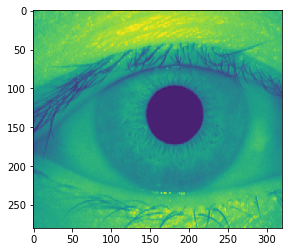

In [49]:
img_color = cv2.imread(img_file_path)
img_RGB = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_RGB, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)

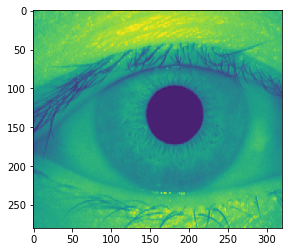

In [52]:
img_gray2 = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray2)

In [240]:
def IrisLocalization(img):
    #img = img_gray
    ymax, xmax = img.shape
    ## step 1: project to roughly estimate (Xp, Yp)
    Xp = np.sum(img,0).argmin()
    Yp = np.sum(img,1).argmin()
    ## step 2: binarize a 120x120 region centered at (Xp, Yp)
    crop_xmin, crop_xmax = max(Xp-60, 0), min(Xp+60, xmax)
    crop_ymin, crop_ymax = max(Yp-60, 0), min(Yp+60, ymax)
    img_120 = img[crop_ymin:crop_ymax, crop_xmin:crop_xmax]
    _, img_120_bi = cv2.threshold(img_120,np.median(img_120), 255, 
                                  cv2.THRESH_BINARY)
    # update a more accuarte Xp, Yp
    circles = cv2.HoughCircles(img_120_bi,cv2.HOUGH_GRADIENT,1,100,
                                param1=200,param2=10,
                               minRadius=15,maxRadius=100)
    if circles is not None:
        circle = circles[0,:][0]
        circle = np.uint16(np.around(circle))
        Xp = crop_xmin + circle[0]
        Yp = crop_ymin + circle[1]
    ## step 3: calcuate the exact parameters of the two circles
    ## using edge detection(Canny) and Hough transformation
    new_xmin, new_xmax = max(Xp-140, 0), min(Xp+140, xmax)
    new_ymin, new_ymax = max(Yp-160, 0), min(Yp+160, ymax)
    recentered_img = img[new_ymin:new_ymax, new_xmin:new_xmax]
    blured_copy = cv2.medianBlur(recentered_img, 11)
    mean_val = np.mean(blured_copy)
    lower = int(max(0, 0.66*mean_val))
    upper = int(min(255, 1.33*mean_val))
    #eye_edges1 = cv2.Canny(blured_copy,100,200) 
    #eye_edges2 = cv2.Canny(blured_copy,10,50)
    #eye_edges_iris = cv2.Canny(blured_copy,100,200) 
    eye_edges_pupil = cv2.Canny(blured_copy,lower,upper) 
    eye_edges_iris = cv2.Canny(blured_copy,5,30)
    circles_iris = cv2.HoughCircles(eye_edges_iris,cv2.HOUGH_GRADIENT,1,300,
                            param1=200,param2=20,
                           minRadius=60,maxRadius=150)
    circles_pupil = cv2.HoughCircles(eye_edges_pupil,cv2.HOUGH_GRADIENT,1,300,
                            param1=200,param2=20,
                           minRadius=30,maxRadius=80)
    if circles_pupil is not None:
        circle = circles_pupil[0,:][0]
        pupil_circle = np.uint16(np.around(circle))
        pupil_circle[0] = pupil_circle[0]+new_xmin
        pupil_circle[1] = pupil_circle[1]+new_ymin
    if circles_iris is not None:
        circle = circles_iris[0,:][0]
        iris_circle = np.uint16(np.around(circle))
        iris_circle[0] = iris_circle[0]+new_xmin
        iris_circle[1] = iris_circle[1]+new_ymin
    
    return pupil_circle, iris_circle

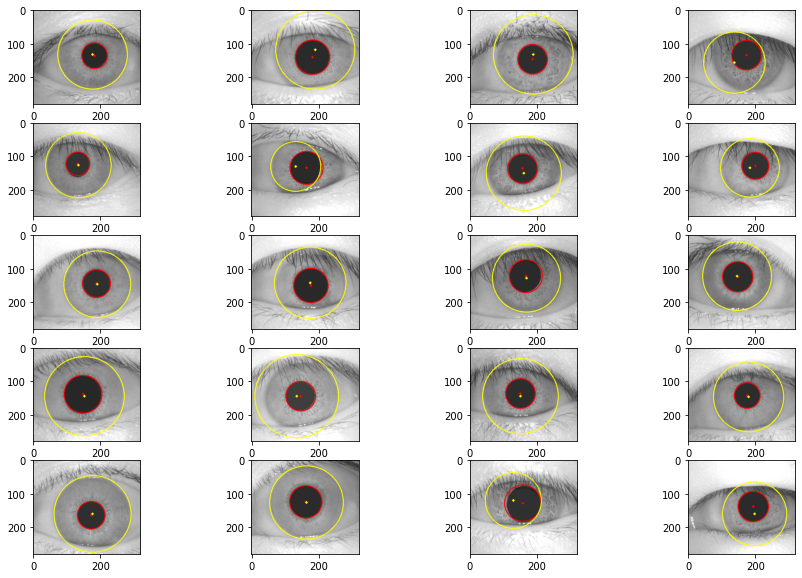

In [241]:
# see function
img_loc_dir = "../datasets/CASIA Iris Image Database (version 1.0)/"
#f, axarr = plt.subplots(5,4, figsize=(15,10))

plt.figure(figsize=(15,10))
for i in range(20):
    str_num = str(i+1).zfill(3)
    img_file_name = str_num + "_1_1.bmp"
    img_file_path = img_loc_dir + str_num + '/1/' + img_file_name
    #print(img_file_path)
    img_color = cv2.imread(img_file_path)
    img_gray2 = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    pupil, iris =  IrisLocalization(img_gray2)
    #print((pupil, iris))
    plt.subplot(5, 4, i+1)
    cimg = img_color.copy()
    cv2.circle(cimg,(pupil[0],pupil[1]),pupil[2],(255,0,0),2)
    cv2.circle(cimg,(pupil[0],pupil[1]),2,(255,0,0),3)
    
    cv2.circle(cimg,(iris[0],iris[1]),iris[2],(255,255,0),2)
    cv2.circle(cimg,(iris[0],iris[1]),2,(255,255,0),3)
    
    plt.imshow(cimg)

In [249]:
# normalization
def IrisNormalization(img, pupil, iris):
    # 64*512 MxN
    M, N = 64, 512
    norm_img = np.zeros((M, N))
    pupil_x, pupil_y, pupil_r  = pupil
    iris_x, iris_y, iris_r = iris
    
    for Y in range(M):
        for X in range(N):
            theta = 2*np.pi*X/N
            yp = pupil_x + pupil_r*np.sin(theta)
            xp = pupil_y + pupil_r*np.cos(theta)

            # get the outer boundary coordinate
            yi = iris_x + iris_r*np.sin(theta)
            xi = iris_y + iris_r*np.cos(theta)

            x = min(int(xp + (xi-xp)*Y/M),319)
            y = min(int(yp + (yi-yp)*Y/M),279)
            
            norm_img[Y][X] = img[y][x]
    
    return norm_img

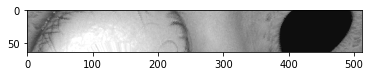

In [252]:
pupil, iris =  IrisLocalization(img_gray2)
norm_img = IrisNormalization(img_gray2, pupil, iris)
plt.imshow(norm_img, cmap = 'gray')

In [253]:
from skimage.filters import rank
import skimage.morphology as morp

In [264]:
# image enhancement
##we first approximate intensity variations across the whole image. The mean of each
##16x16 small block constitutes a coarse estimate of the
##background illumination.

def ImageEnhancement(img, norm_img):
    # background illumination: 16x16
    img_bg = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            block = img[i:i+16, j:j+16]
            #block = block.astype('uint8')
            img[i, j] = np.mean(block)
    
    resized_bg = cv2.resize(img_bg, (norm_img.shape[1], norm_img.shape[0]), 
                         interpolation=cv2.INTER_CUBIC)

    enhanced_light_img = norm_img - resized_bg
    # histogram equalization in each 32x32 region
    #kernel = morp.disk(32)
    #enhanced_img = rank.equalize(enhanced_light_img.astype(np.uint8), 
    #                          selem=kernel)
    #enhanced_img = cv2.GaussianBlur(img_local, (5, 5), 0)
    enhanced_img = enhanced_light_img.copy()
    for i in range(enhanced_img.shape[0]):
        for j in range(enhanced_img.shape[1]):
            block = enhanced_img[i:i+32, j:j+32]
            block = block.astype('uint8')
            dest = cv2.equalizeHist(block)
            enhanced_img[i:i+32, j:j+32] = dest            
    
    return enhanced_img

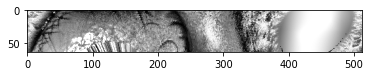

In [259]:
# use skimage
enhanced_img = ImageEnhancement(img_gray2, norm_img)
plt.imshow(enhanced_img, cmap = 'gray')

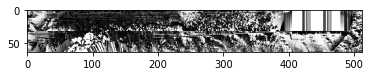

In [263]:
# use for-loop
enhanced_img = ImageEnhancement(img_gray2, norm_img)
plt.imshow(enhanced_img, cmap = 'gray')